In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from IPython.display import display

from sklearn.model_selection import train_test_split

pd.options.display.max_columns = None

# Import Data

In [9]:
day_raw = pd.read_csv('data/day.csv')
hour_raw = pd.read_csv('data/hour.csv')

# Explore

In [10]:
hour_raw.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [11]:
hour_raw.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

## Month and Season are duplicative - We'll keep the one that correlates more with cnt/casual/registered bike shares

In [12]:
hour_raw.corr()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


## Season has higher correlation than month, we'll use season

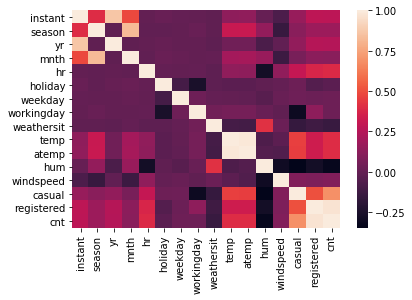

In [13]:
ax = sns.heatmap(hour_raw.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247D11465F8>,
      dtype=object)

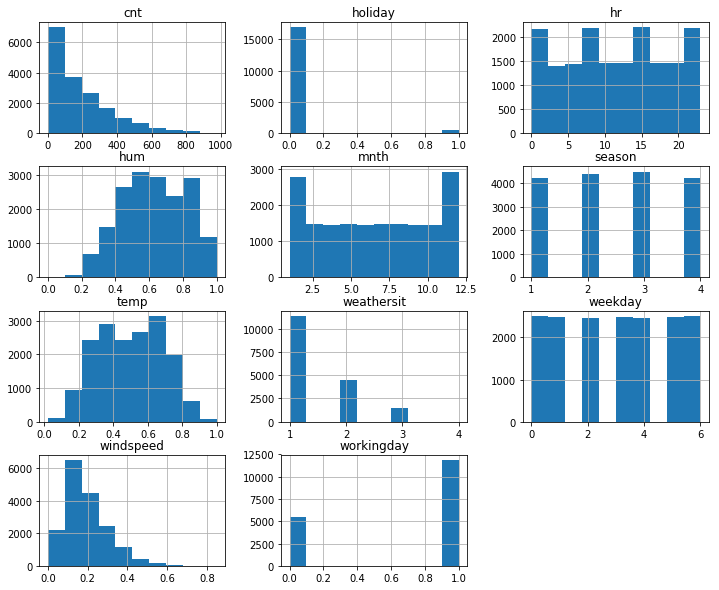

In [14]:
hour_raw[['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum',
         'windspeed', 'cnt']].hist(figsize=(12,10))

In [15]:
hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)

hour_raw['sqr_cnt'] = hour_raw.cnt**(1/5)
min(hour_raw.sqr_cnt)

1.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247D11764E0>,
      dtype=object)

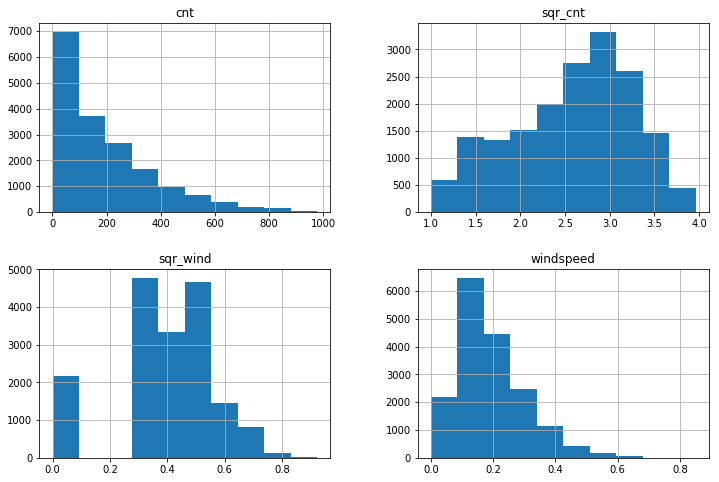

In [16]:
hour_raw[['windspeed', 'sqr_wind', 'sqr_cnt', 'cnt']].hist(figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247D16C9E48>,
      dtype=object)

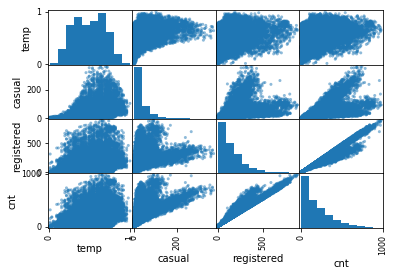

In [17]:
pd.plotting.scatter_matrix(hour_raw[['temp', 'casual','registered','cnt']])

# First Attempt - normalized hour data as norm_hr, hour is kept numeric

In [18]:
hour_raw = pd.read_csv('data/hour.csv')
#hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)

season_dummies = pd.get_dummies(data=hour_raw.season, prefix='season')
weathersit_dummies=pd.get_dummies(data=hour_raw.weathersit, prefix='weathersit')
weekday_dummies = pd.get_dummies(data=hour_raw.weekday, prefix='weekday')

hour_raw = pd.concat([hour_raw, season_dummies, weathersit_dummies, weekday_dummies], axis=1)
hour_raw.drop(columns=['season_1', 'weathersit_4', 'weekday_6'], inplace = True)

hour_raw['norm_hr'] = (hour_raw.hr-min(hour_raw.hr))/(max(hour_raw.hr)-min(hour_raw.hr))

lin_target = hour_raw.cnt
features_df = hour_raw.drop(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'weathersit', 'atemp', 'casual', 'registered', 'cnt'], axis=1)
predictor_int = sm.add_constant(features_df)

X_train, X_test, y_train, y_test = train_test_split(features_df, lin_target, test_size = 0.4)

model = sm.OLS(y_train, X_train).fit()
model.summary()

C:\Users\prayt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     325.7
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:45:42   Log-Likelihood:                -66721.
No. Observations:               10427   AIC:                         1.335e+05
Df Residuals:                   10409   BIC:                         1.336e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
holiday        -18.9616     52.719     -0.360      0.719    -122.300      84.377
weekday          2.7409     24.363      0.113      0.910     -45.015      50.496
workingday      10.3433     52.227      0.198      0.843     -92.032     112.718
temp           379.8310     12.365     30.719      0.000     355.594     404.068
hum           -205.2954      9.149    -22.439      0.000    -223.229    -187.362
windspeed       11.0246     12.522      0.880      0.379     -13.521      35.571
season_2        12.5749      5.093      2.469      0.014       2.591      22.559
season_3       -20.1255      6.548     -3.074      0.002     -32.961      -7.290
season_4        56.9178      4.478     12.710      0.000      48.140      65.696
weathersit_1    14.9433    145.743      0.103      0.918    -270.740     300.627
weathersit_2    24.7134    145.731      0.170      0.865    -260.948     310.375
weathersit_3   -11.7563    145.753     -0.081      0.936    -297.459     273.947
weekday_0        8.6576    146.180      0.059      0.953    -277.884     295.199
weekday_1       -1.9280     69.692     -0.028      0.978    -138.538     134.682
weekday_2        0.0727     45.409      0.002      0.999     -88.937      89.082
weekday_3        4.6151     21.134      0.218      0.827     -36.812      46.042
weekday_4       -7.2454      5.165     -1.403      0.161     -17.370       2.879
weekday_5       -4.1327     28.123     -0.147      0.883     -59.258      50.993
norm_hr        167.5558      5.050     33.181      0.000     157.657     177.454
==============================================================================
Omnibus:                     2564.207   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5915.372
Skew:                           1.389   Prob(JB):                         0.00
Kurtosis:                       5.430   Cond. No.                     5.74e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.66e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Predictors -> season, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt, spring, summer, fall

# nth attempt - changed hours to dummy vars, transform wind speed, transform target

In [19]:
hour_raw = pd.read_csv('data/hour.csv')

season_dummies = pd.get_dummies(data=hour_raw.season, prefix='season')
weathersit_dummies=pd.get_dummies(data=hour_raw.weathersit, prefix='weathersit')
weekday_dummies = pd.get_dummies(data=hour_raw.weekday, prefix='weekday')
hr_dummies = pd.get_dummies(data=hour_raw.hr, prefix='hr')

hour_raw = pd.concat([hour_raw, season_dummies, weathersit_dummies, weekday_dummies, hr_dummies], axis=1)
hour_raw.drop(columns=['season_1', 'weathersit_4', 'weekday_6','hr_0'], inplace = True)

hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)
hour_raw['sqr_cnt'] = hour_raw.cnt**(1/5)


lin_target = hour_raw.sqr_cnt
features_df = hour_raw.drop(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'weathersit', 'atemp', 'casual', 'registered', 'cnt', 'hr', 'sqr_wind', 'sqr_cnt'], axis=1)
predictor_int = sm.add_constant(features_df)

X_train, X_test, y_train, y_test = train_test_split(predictor_int, lin_target, test_size = 0.2)

model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)
print('test r2', r2_score(y_test, model.predict(X_test))) 
print('train r2', r2_score(y_train, model.predict(X_train)))

new_df = pd.DataFrame(model.predict(X_train)-y_train)
new_df.head(20)
#model.summary()

test r2 0.7965264242881815
train r2 0.7883433708078067


,0
10066,-0.086961
107,0.361233
6470,-0.105262
15609,-0.014011
6416,0.018778
2882,0.146084
4413,0.073437
6276,-0.393215
6159,-0.203343
6476,-0.318600


## Need to transform results back to original form (x^(1/5))^5 = x 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247D1737630>]],
      dtype=object)

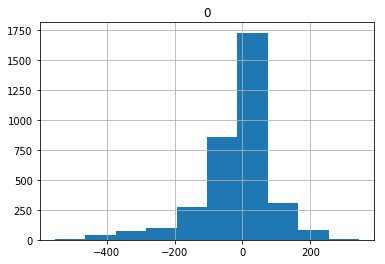

In [20]:
pd.DataFrame(model.predict(X_test)**5-y_test**5).hist()

## R^2 is much higher now - so is test!  R2 same for train/test, not overfit
## residuals are normal which is also good.  

# Now for LOGISTIC REGRESSION

In [1]:
import pickle

In [2]:
logistic_data = pickle.load(open('bikes_logistic.pkl', 'rb'))

In [7]:
logistic_data.above_avg_casual.value_counts()

0    11121
1     6258
Name: above_avg_casual, dtype: int64

In [5]:
logistic_data

,temp,hum,windspeed,season_spring,season_summer,season_winter,yr_2012,hr_1,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_2,hr_20,hr_21,hr_22,hr_23,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,holiday_not_holiday,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,workingday_working,weathersit_heavy_rain_snow,weathersit_light_rain_snow,weathersit_mist,above_avg_casual
dteday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,-1.427116,0.932170,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2011-01-01,-1.514128,0.928318,0.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2011-01-01,-1.514128,0.928318,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2011-01-01,-1.427116,0.908560,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2011-01-01,-1.427116,0.908560,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2011-01-01,-1.427116,0.908560,0.0896,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2011-01-01,-1.514128,0.928318,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2011-01-01,-1.609438,0.950969,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2011-01-01,-1.427116,0.908560,0.0000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
regr = LogisticRegression(C=1e5)

regr.fit(features_df, )

In [43]:
hour_raw['holiday'][1]

0

In [55]:
# hour_raw['higher_casual'] = 1 if (hour_raw['casual']/hour_raw['cnt']) >= .5 else 0

hour_raw['higher_casual'] = [1 if hour_raw['casual'][x]/hour_raw['cnt'][x] >= .5 else 0 for x in list(range(0,len(hour_raw)))] 

# hour_raw['higher_casual'] = 0

# ho
# hour_raw
hour_raw.higher_casual.value_counts()
hour_raw.loc[hour_raw['higher_casual']==1,:]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,sqr_wind,sqr_cnt,higher_casual
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1.148698,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1.695218,1
13,14,2011-01-01,1,0,1,13,0,6,0,2,0.46,0.4545,0.72,0.2985,47,47,94,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.546352,2.480993,1
28,29,2011-01-02,1,0,1,4,0,0,0,2,0.46,0.4545,0.94,0.1940,2,1,3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.440454,1.245731,1
210,211,2011-01-10,1,0,1,1,0,1,1,1,0.12,0.1212,0.50,0.2836,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.532541,1.000000,1
351,352,2011-01-16,1,0,1,3,0,0,0,1,0.22,0.2727,0.69,0.0000,9,6,15,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1.718772,1
353,354,2011-01-16,1,0,1,5,0,0,0,2,0.26,0.2576,0.56,0.1642,1,1,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.405216,1.148698,1
411,412,2011-01-19,1,0,1,4,0,3,1,3,0.22,0.2273,0.93,0.1343,1,1,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.366470,1.148698,1
508,509,2011-01-23,1,0,1,7,0,0,0,1,0.08,0.1061,0.58,0.1642,1,1,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.405216,1.148698,1
598,599,2011-01-28,1,0,1,3,0,5,1,2,0.20,0.2273,0.75,0.1045,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.323265,1.000000,1


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

hour_raw = pd.read_csv('data/hour.csv')

season_dummies = pd.get_dummies(data=hour_raw.season, prefix='season')
weathersit_dummies=pd.get_dummies(data=hour_raw.weathersit, prefix='weathersit')
weekday_dummies = pd.get_dummies(data=hour_raw.weekday, prefix='weekday')
hr_dummies = pd.get_dummies(data=hour_raw.hr, prefix='hr')

hour_raw = pd.concat([hour_raw, season_dummies, weathersit_dummies, weekday_dummies, hr_dummies], axis=1)
hour_raw.drop(columns=['season_1', 'weathersit_4', 'weekday_6','hr_0'], inplace = True)

hour_raw['sqr_wind'] = hour_raw.windspeed**(1/2)
hour_raw['sqr_cnt'] = hour_raw.cnt**(1/5)

#create target var for Log Reg
hour_raw['higher_casual'] = [1 if hour_raw['casual'][x]/hour_raw['cnt'][x] >= .5 else 0 for x in list(range(0,len(hour_raw)))] 


logR_target = hour_raw['higher_casual']
features_df = hour_raw.drop(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'weathersit', 'atemp', 'casual', 'registered', 'cnt', 'hr', 'sqr_wind', 'sqr_cnt', 'higher_casual'], axis=1)
predictor_int = features_df

X_train, X_test, y_train, y_test = train_test_split(predictor_int, logR_target, test_size = 0.2)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=400,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for None: 0.8591466718266253
LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=400,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for Balanced: 0.8638254643962849
LogisticRegression(C=1000000000000.0, class_weight={1: 2, 0: 1}, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=400,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
AUC for 2 to 1: 0.8598897058823528
LogisticRegression(C=1000000000000.0, class_wei

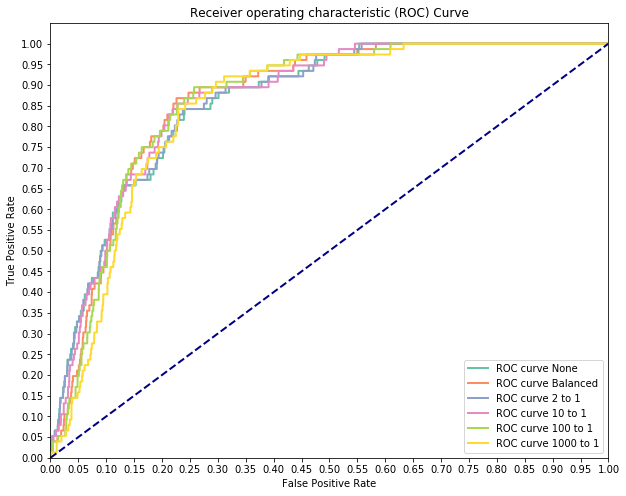

In [71]:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, max_iter=400, class_weight=weight, solver='lbfgs') #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()